In [2]:
#imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.io as scipy
from scipy.spatial.distance import pdist, squareform
from scipy.ndimage import label as connected_components
from ipywidgets import interact, Dropdown
from IPython.display import display
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.decomposition import PCA, NMF

ims_cube = scipy.loadmat("ims_cube.mat")['ims_cube']

# 1. Data Understanding
## 1.1 Plot der räumlichen Verteilung einzelner Features/Kanäle


In [3]:
# Print basic information
print(f"Shape of ims_cube: {ims_cube.shape}")

n_channels = ims_cube.shape[2]
print(f"Number of channels: {n_channels}")

# Plot channels
def plot_channels(preset_group):
    # Plot all channels in a dynamic grid
    if preset_group == "All Channels":
        channels_to_show = list(range(n_channels))
        cols = 4  # Adjust as needed
        rows = (n_channels + cols - 1) // cols  # Ceiling division
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
        
        # Handle different subplot configurations
        if n_channels == 1:
            axes = [axes]
        elif rows == 1:
            axes = axes if hasattr(axes, '__iter__') else [axes]
        else:
            axes = axes.ravel()
        
        for i, channel_idx in enumerate(channels_to_show):
            im = axes[i].imshow(ims_cube[:, :, channel_idx], cmap='viridis')
            axes[i].set_title(f'Channel {channel_idx + 1}')  # Changed to 1-based indexing
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i])
        
        # Hide unused subplots
        for i in range(n_channels, rows * cols):
            if i < len(axes):
                axes[i].set_visible(False)

    # Plot up to 6 plots at once
    else:
        # Parse the preset group to get channel range
        group_start = int(preset_group.split('-')[0]) - 1  # 0-based indexing
        group_end = min(group_start + 6, n_channels)
        channels_to_show = list(range(group_start, group_end))
        
        cols = 3
        rows = 2
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 10))
        axes = axes.ravel()
        
        for i, channel_idx in enumerate(channels_to_show):
            im = axes[i].imshow(ims_cube[:, :, channel_idx], cmap='viridis')
            axes[i].set_title(f'Channel {channel_idx + 1}')  # 1-based indexing
            axes[i].axis('off')
            plt.colorbar(im, ax=axes[i])
        
        # Hide unused subplots
        for i in range(len(channels_to_show), 6):
            axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Create preset groups
preset_options = ["All Channels"] 
for i in range(0, n_channels, 6):
    start = i + 1
    end = min(i + 6, n_channels)
    preset_options.append(f"{start}-{end}")

# Create widget
preset_selector = Dropdown(
    options=preset_options,
    value=preset_options[1], 
    description='Channels:',
    disabled=False,
)

# Interactive widget
interact(plot_channels, preset_group=preset_selector)

Shape of ims_cube: (128, 128, 191)
Number of channels: 191


interactive(children=(Dropdown(description='Channels:', index=1, options=('All Channels', '1-6', '7-12', '13-1…

<function __main__.plot_channels(preset_group)>

## 1.2 Plot der enthaltenen Spektren


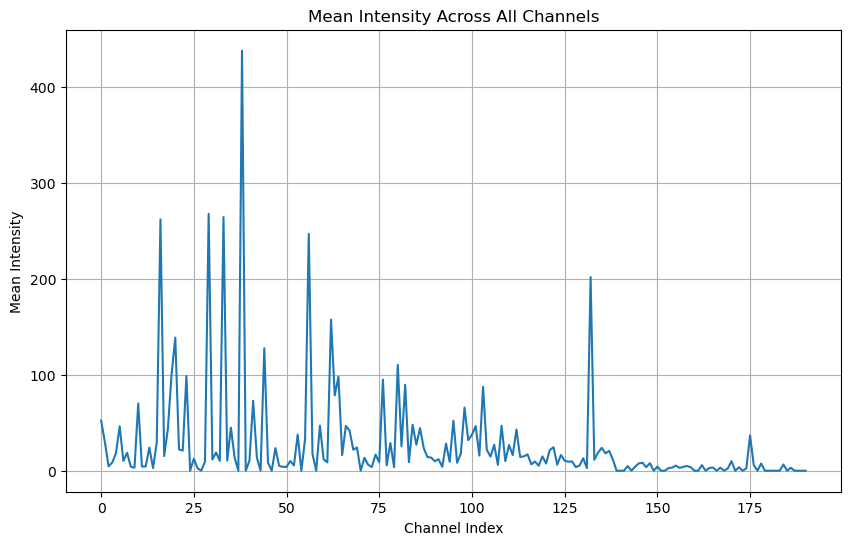

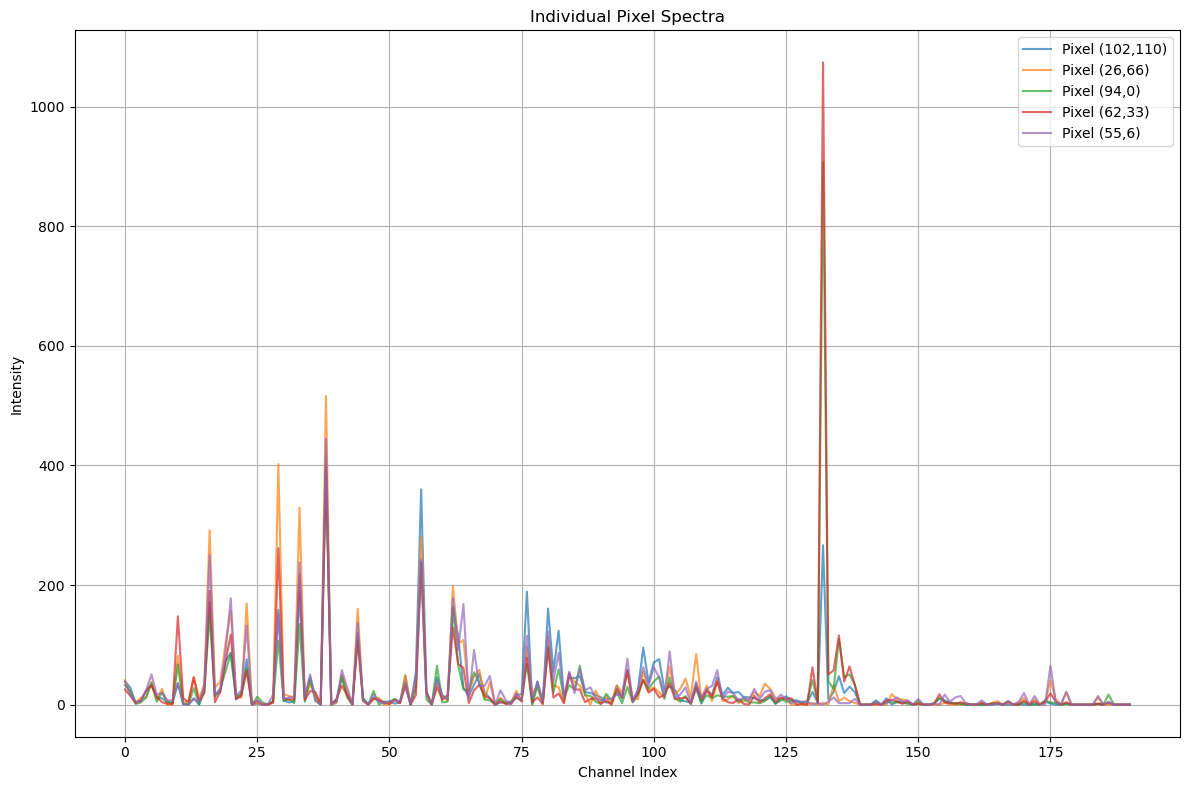

In [4]:
# Plot mean intensity across all channels
plt.figure(figsize=(10, 6))
mean_intensity = np.mean(ims_cube, axis=(0, 1))
plt.plot(mean_intensity)
plt.title('Mean Intensity Across All Channels')
plt.xlabel('Channel Index')
plt.ylabel('Mean Intensity')
plt.grid(True)
plt.show()


# Plot spectra for a few random pixels
plt.figure(figsize=(12, 8))
n_samples = 5
height, width, n_channels = ims_cube.shape
for i in range(n_samples):
    # Random pixel coordinates
    row = np.random.randint(0, height)
    col = np.random.randint(0, width)
    spectrum = ims_cube[row, col, :]
    plt.plot(spectrum, alpha=0.7, label=f'Pixel ({row},{col})')

plt.title('Individual Pixel Spectra')
plt.xlabel('Channel Index')
plt.ylabel('Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Eckdaten zur Spektralanalyse

In [17]:
# Details about average spectrum

print(f"=== AVERAGE SPECTRUM SPECTRAL ANALYSIS ===\n")
print(f"Min intensity: {np.min(mean_intensity):.3f}")
print(f"Max intensity: {np.max(mean_intensity):.3f}")
print(f"Mean intensity: {np.mean(mean_intensity):.3f}")
print(f"Std deviation: {np.std(mean_intensity):.3f}")

# Find peaks
peak_indices = []
for i in range(1, len(mean_intensity)-1):
    if mean_intensity[i] > mean_intensity[i-1] and mean_intensity[i] > mean_intensity[i+1]:
        peak_indices.append(i)

if peak_indices:
    peak_values = mean_intensity[peak_indices]
    # Get top 3 peaks
    top_peaks_idx = np.argsort(peak_values)[-3:][::-1]
    top_peak_channels = [peak_indices[i] for i in top_peaks_idx]
    top_peak_values = [peak_values[i] for i in top_peaks_idx]
    print(f"Top peaks at channels: {top_peak_channels} "
          f"with values: {[f'{val:.3f}' for val in top_peak_values]}")

# Find global maximum
max_channel = np.argmax(mean_intensity)
print(f"Global maximum at channel {max_channel}: {mean_intensity[max_channel]:.3f}")

# Find global minimum
min_channel = np.argmin(mean_intensity)
print(f"Global minimum at channel {min_channel}: {mean_intensity[min_channel]:.3f}")

print()


# Additional details for the entire dataset

print("=== DATASET OVERVIEW ===")
print(f"Total number of spectra (pixels): {height * width}")
print(f"Number of spectral channels: {n_channels}")
print(f"Overall min intensity: {np.min(ims_cube):.3f}")
print(f"Overall max intensity: {np.max(ims_cube):.3f}")
print(f"Overall mean intensity: {np.mean(ims_cube):.3f}")
print(f"Overall std deviation: {np.std(ims_cube):.3f}")

# Channel-wise statistics
channel_means = np.mean(ims_cube, axis=(0,1))
channel_stds = np.std(ims_cube, axis=(0,1))

most_variable_channel = np.argmax(channel_stds)
least_variable_channel = np.argmin(channel_stds)

print(f"Most variable channel: {most_variable_channel} (std: {channel_stds[most_variable_channel]:.3f})")
print(f"Least variable channel: {least_variable_channel} (std: {channel_stds[least_variable_channel]:.3f})")

=== AVERAGE SPECTRUM SPECTRAL ANALYSIS ===

Min intensity: 0.000
Max intensity: 437.762
Mean intensity: 27.321
Std deviation: 54.405
Top peaks at channels: [38, 29, 33] with values: ['437.762', '267.803', '264.411']
Global maximum at channel 38: 437.762
Global minimum at channel 24: 0.000

=== DATASET OVERVIEW ===
Total number of spectra (pixels): 16384
Number of spectral channels: 191
Overall min intensity: 0.000
Overall max intensity: 2417.062
Overall mean intensity: 27.321
Overall std deviation: 64.665
Most variable channel: 132 (std: 405.127)
Least variable channel: 24 (std: 0.000)


## 1.3 Erkenntnisse aus der Datenanalyse

| Beobachtung | Konsequenz für die Datenverarbeitung |
| :--- | :--- |
| **Datenformat (Dimension)** | Die 128x128-Bilder müssen in eine 2D-Matrix umgewandelt werden, damit sie verarbeitet werden können. |
| **Dynamikbereich:** Große Amplitudenunterschiede | **Normalisierung/Standardisierung:** Skalierung der Daten ist zwingend |
| **Heterogenität:** Kanäle zeigen unterschiedliche räumliche Muster | ggf. **Feature Selection** zur Identifikation der informativsten Kanäle |
| **Korrelation:** Ähnliche Strukturen deuten auf Redundanz hin | ggf. **Dimensionsreduktion** zur Entfernung redundanter Informationen |


# 2. Data Preparation
## 2.1 Datenumformung

### Umwandlung des 3D-Datenwürfels in eine 2D Matrix

In [21]:
# Reshape data cube into 2D matrix (samples x features)
# Each pixel becomes a sample, each channel becomes a feature

print(f"Original shape: {ims_cube.shape}")

X = ims_cube.reshape(-1, n_channels)

print(f"Reshaped matrix shape: {X.shape}")
print(f"Number of samples (pixels): {X.shape[0]}")
print(f"Number of features (channels): {X.shape[1]}")

# Verify the transformation
print(f"\nVerification:")
print(f"Original total pixels: {height} * {width} = {height * width}")
print(f"Matrix samples: {X.shape[0]}")
print(f"Match: {height * width == X.shape[0]}")


Original shape: (128, 128, 191)
Reshaped matrix shape: (16384, 191)
Number of samples (pixels): 16384
Number of features (channels): 191

Verification:
Original total pixels: 128 * 128 = 16384
Matrix samples: 16384
Match: True


## 2.2 Datenstandardisierung

### Zentrierung auf Mittelwert Null und Skalierung auf Einheitsvarianz

In [34]:
# Standardize the features with StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Standardized matrix shape: {X_scaled.shape}\n")

# Verify standardization per feature
print(f"Verifying with example values (first 15):")
print(" Per-feature means:", np.round(np.mean(X_scaled, axis=0)[:15],3))
print(" Per-feature stds:", np.std(X_scaled, axis=0)[:15])

Standardized matrix shape: (16384, 191)

Verifying with example values (first 15):
 Per-feature means: [ 0.  0. -0.  0.  0. -0.  0.  0. -0.  0.  0.  0. -0. -0.  0.]
 Per-feature stds: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# 3. Modeling & Evaluation: Clustering
## 3.1 Verfahrensauswahl
### Modellierung: k-Means Clustering für MSI-Daten

| Aspekt | k-Means Clustering (Ausgewähltes Verfahren) | Alternative Verfahren (DBSCAN, GMM, Hierarchical, etc.) |
| :--- | :--- | :--- |
| **Grundprinzip** | Gruppiert bei MSI-Daten alle Pixel in eine vorher festgelegte Anzahl (k) von Clustern, die jeweils ein bestimmtes Material oder Gewebe repräsentieren sollen. Dabei wird jedes Pixel dem Cluster-Zentrum zugeordnet, dessen durchschnittliches Spektrum seinem eigenen Spektrum am ähnlichsten ist. Durch diesen iterativen Prozess entstehen am Ende stabile Gruppen von Pixeln mit sehr ähnlichen spektralen Signaturen. | Nutzen andere Metriken wie Dichte (DBSCAN) oder Wahrscheinlichkeitsverteilungen (GMM). |
| **Eignung für MSI** | **Sehr gut**: Spektrale Ähnlichkeit wird direkt in geringe Distanz übersetzt. Cluster-Zentren sind als "typische" Materialspektren interpretierbar. | **Weniger geeignet**:<br>- DBSCAN hat Schwierigkeiten mit hochdimensionalen Daten und der Parameterwahl (ε).<br>- GMM ist komplexer ohne klaren Vorteil. |
| **Skalierbarkeit** | **Hoch**: Effiziente Komplexität ($O(n \cdot k \cdot i)$) ideal für große MSI-Datensätze mit vielen Pixeln. | **Gering**: <br>- Hierarchical Clustering ($O(n^3)$)<br>- DBSCAN ($O(n^2)$)<br>-  Spectral Clustering ($O(n^3)$)<br> ->sind alle für große Datenmengen zu rechenintensiv. |
| **Parameter** | **Einfach**: Im Wesentlichen muss nur die Anzahl der Cluster (k) bestimmt werden. | **Komplex**: DBSCAN (ε, min_samples), GMM (Anzahl, Kovarianzen) und Spectral Clustering erfordern eine aufwändigere Parameterwahl. |
| **Annahmen** | **Passend**: Annahmen wie sphärische und konvexe Cluster werden durch die Standardisierung der Daten gut unterstützt. | - |
| **Vorteile** | Schnelle Verarbeitung<br>Leicht interpretierbare Ergebnisse<br>Robust bei standardisierten Daten<br>Etabliertes Verfahren | - |
| **Nachteile** | Kann bei stark überlappenden Spektren oder Rauschen an Grenzen stoßen. | Meist zu langsam oder unpraktikabel für die Analyse von MSI-Bildern. |

## 3.2 Parametrisierung

### k=6, da in der Aufgabe 5 tissues genannt + Hintergrund

In [9]:
# # Since the exercise specifies 5 classes, we'll use k=5
# # But let's still show the analysis for comparison
# target_k = 5

# print(f"=== USING DOMAIN KNOWLEDGE: k={target_k} ===")
# print("Exercise specification: Searching for 5 different classes")
# print(f"Using k={target_k} based on this requirement")

# # Perform clustering with k=5
# kmeans_final = KMeans(n_clusters=target_k, random_state=42, n_init=10)
# labels = kmeans_final.fit_predict(X_scaled)

# # Calculate metrics for k=5
# silhouette_k5 = silhouette_score(X_scaled, labels)

# print(f"\nResults for k={target_k}:")
# print(f"Silhouette Score: {silhouette_k5:.4f}")
# print(f"Inertia: {kmeans_final.inertia_:.1f}")

# # Show how this compares to your data-driven analysis
# if target_k-1 < len(silhouette_scores):  # Check if k=5 was in your range
#     data_driven_score = silhouette_scores[target_k-2]  # k_range starts at 2
#     print(f"This matches our calculated score: {data_driven_score:.4f}")
    
#     rank_position = sorted(silhouette_scores, reverse=True).index(data_driven_score) + 1
#     print(f"k=5 ranks #{rank_position} out of {len(silhouette_scores)} tested values")

# print(f"\nNumber of samples per cluster:")
# unique_labels, counts = np.unique(labels, return_counts=True)
# for label, count in zip(unique_labels, counts):
#     print(f"  Cluster {label}: {count} samples ({count/len(labels)*100:.1f}%)")

## 3.3 Durchführung und Visualisierung

=== K-MEANS CLUSTERING ANALYSIS ===
Using k=5 clusters as specified
Data shape: (16384, 191)

Clustering Results:
Silhouette Score: 0.1278
Inertia (Within-cluster sum of squares): 1658134.7

Cluster Distribution:
  Cluster 1: 3,830 pixels (23.4%)
  Cluster 2: 532 pixels (3.2%)
  Cluster 3: 3,463 pixels (21.1%)
  Cluster 4: 6,473 pixels (39.5%)
  Cluster 5: 2,086 pixels (12.7%)


Text(0, 0.5, 'Y coordinate (pixels)')

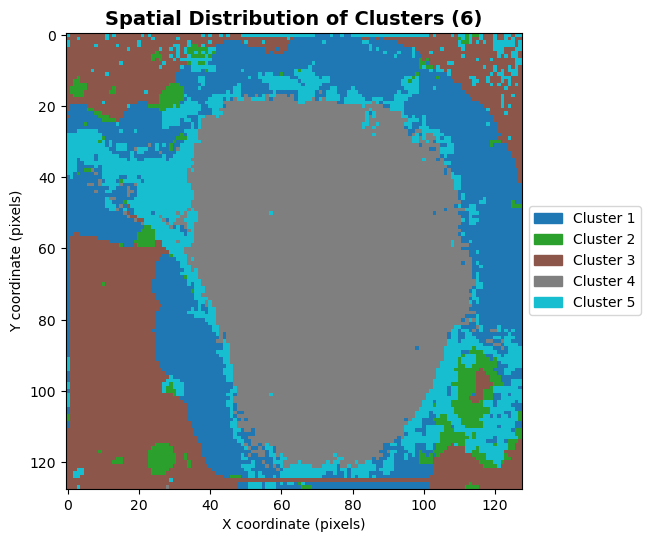

In [10]:
# Perform k-means clustering with k=5
print("=== K-MEANS CLUSTERING ANALYSIS ===")
print(f"Using k=5 clusters as specified")
print(f"Data shape: {X_scaled.shape}")

# Perform clustering

kmeans_final = KMeans(n_clusters=5, random_state=42, n_init=10)
labels = kmeans_final.fit_predict(X_scaled)

# Calculate performance metrics
silhouette_avg = silhouette_score(X_scaled, labels)
inertia = kmeans_final.inertia_

print(f"\nClustering Results:")
print(f"Silhouette Score: {silhouette_avg:.4f}")
print(f"Inertia (Within-cluster sum of squares): {inertia:.1f}")

# Analyze cluster distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"\nCluster Distribution:")
for label, count in zip(unique_labels, counts):
    percentage = count/len(labels)*100
    print(f"  Cluster {label + 1}: {count:,} pixels ({percentage:.1f}%)")

# Reshape labels back to spatial dimensions for visualization
labels_spatial = labels.reshape(height, width)

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 15))

# 1. Main cluster map
ax1 = plt.subplot(2, 3, 1)
cluster_map = plt.imshow(labels_spatial, cmap='tab10', interpolation='nearest')
plt.title('Spatial Distribution of Clusters (6)', fontsize=14, fontweight='bold')

# Create custom legend with cluster labels
colors = plt.cm.tab10(np.linspace(0, 1, 5))
legend_elements = [mpatches.Patch(color=colors[i], label=f'Cluster {i+1}') for i in range(5)]
plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('X coordinate (pixels)')
plt.ylabel('Y coordinate (pixels)')

In [11]:
# 2. Individual cluster maps
print("=== INDIVIDUAL CLUSTER VISUALIZATIONS ===\n")

# Create an interactive widget for individual cluster selection
def show_individual_cluster(cluster_id):
    plt.figure(figsize=(8, 6)) 
    
    # Create a mask for the selected cluster
    cluster_mask = (labels_spatial == cluster_id).astype(float)
    cluster_mask[cluster_mask == 0] = np.nan  # Make background transparent
    
    plt.imshow(cluster_mask, cmap='Blues', alpha=1, interpolation='nearest', 
               vmin=0, vmax=1)
    plt.title(f'Cluster {cluster_id + 1}\n({counts[cluster_id]:,} pixels, {counts[cluster_id]/len(labels)*100:.1f}%)', 
              fontsize=16, fontweight='bold')
    plt.xlabel('X coordinate (pixels)')
    plt.ylabel('Y coordinate (pixels)')
    
    # Replace colorbar with custom legend
    cluster_patch = mpatches.Patch(color='blue', label=f'Cluster {cluster_id + 1}')
    #background_patch = mpatches.Patch(color='white', label='Background')
    #plt.legend(handles=[cluster_patch], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Additional cluster statistics
    print(f"\n=== CLUSTER {cluster_id + 1} DETAILS ===")
    print(f"Number of pixels: {counts[cluster_id]:,}")
    print(f"Percentage of total: {counts[cluster_id]/len(labels)*100:.2f}%")
    
    # Find connected components for spatial coherence analysis
    cluster_binary = (labels_spatial == cluster_id).astype(int)
    labeled_array, num_components = connected_components(cluster_binary)
    
    if num_components > 0:
        component_sizes = np.bincount(labeled_array.flat)[1:]  # Exclude background (0)
        largest_component = np.max(component_sizes)
        coherence = largest_component / counts[cluster_id]
        
        print(f"Spatial coherence: {coherence:.3f}")
        print(f"Number of separate components: {num_components}")
        print(f"Largest component size: {largest_component} pixels")
        print(f"Average component size: {np.mean(component_sizes):.1f} pixels")

# Create interactive widget
cluster_dropdown = Dropdown(
    options=[(f'Cluster {i+1}', i) for i in range(5)],
    value=0,
    description='Cluster:',
    disabled=False,
)

print("\n=== INTERACTIVE CLUSTER EXPLORER ===")
interact(show_individual_cluster, cluster_id=cluster_dropdown)

=== INDIVIDUAL CLUSTER VISUALIZATIONS ===


=== INTERACTIVE CLUSTER EXPLORER ===


interactive(children=(Dropdown(description='Cluster:', options=(('Cluster 1', 0), ('Cluster 2', 1), ('Cluster …

<function __main__.show_individual_cluster(cluster_id)>

In [12]:
# # Analyze cluster centroids (representative spectra)
# print(f"\n=== CLUSTER CENTROID ANALYSIS ===")
# centroids = kmeans_final.cluster_centers_

# # Plot cluster centroids
# plt.figure(figsize=(15, 10))

# # Plot all centroids
# plt.subplot(2, 2, 1)
# for i in range(5):
#     plt.plot(centroids[i], label=f'Cluster {i}', linewidth=2, alpha=0.8)
# plt.title('Cluster Centroids (Standardized Spectra)', fontsize=14)
# plt.xlabel('Channel Index')
# plt.ylabel('Standardized Intensity')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Compare centroids pairwise
# plt.subplot(2, 2, 2)
# # Calculate pairwise distances between centroids
# centroid_distances = squareform(pdist(centroids, metric='euclidean'))
# im = plt.imshow(centroid_distances, cmap='viridis')
# plt.title('Pairwise Distances Between Centroids', fontsize=14)
# plt.xlabel('Cluster ID')
# plt.ylabel('Cluster ID')
# plt.colorbar(im, label='Euclidean Distance')

# # Add text annotations manually
# for i in range(centroid_distances.shape[0]):
#     for j in range(centroid_distances.shape[1]):
#         plt.text(j, i, f'{centroid_distances[i, j]:.2f}', 
#                 ha='center', va='center', color='white' if centroid_distances[i, j] < centroid_distances.max()/2 else 'black')

# # Show spectral characteristics per cluster
# plt.subplot(2, 2, 3)
# # Find most discriminative channels (highest variance across centroids)
# centroid_var = np.var(centroids, axis=0)
# top_channels = np.argsort(centroid_var)[-20:]  # Top 20 most variable channels

# for i in range(5):
#     plt.scatter(top_channels, centroids[i, top_channels], 
#                label=f'Cluster {i}', s=50, alpha=0.7)
# plt.title('Most Discriminative Channels', fontsize=14)
# plt.xlabel('Channel Index')
# plt.ylabel('Standardized Intensity')
# plt.legend()
# plt.grid(True, alpha=0.3)

# # Cluster quality metrics
# plt.subplot(2, 2, 4)
# silhouette_vals = silhouette_samples(X_scaled, labels)

# y_lower = 10
# colors = plt.cm.tab10(np.linspace(0, 1, 5))

# for i in range(5):
#     cluster_silhouette_vals = silhouette_vals[labels == i]
#     cluster_silhouette_vals.sort()
    
#     size_cluster_i = cluster_silhouette_vals.shape[0]
#     y_upper = y_lower + size_cluster_i
    
#     plt.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals,
#                       facecolor=colors[i], edgecolor=colors[i], alpha=0.7,
#                       label=f'Cluster {i}')
#     y_lower = y_upper + 10

# plt.axvline(x=silhouette_avg, color="red", linestyle="--", 
#            label=f'Average Score: {silhouette_avg:.3f}')
# plt.xlabel('Silhouette Coefficient Values')
# plt.ylabel('Cluster Label')
# plt.title('Silhouette Analysis', fontsize=14)
# plt.legend()

# plt.tight_layout()
# plt.show()

# # Statistical summary of clusters
# print(f"\n=== DETAILED CLUSTER STATISTICS ===")
# for i in range(5):
#     cluster_data = X_scaled[labels == i]
#     print(f"\nCluster {i} ({counts[i]:,} samples, {counts[i]/len(labels)*100:.1f}%):")
#     print(f"  Mean silhouette score: {silhouette_vals[labels == i].mean():.4f}")
#     print(f"  Std silhouette score: {silhouette_vals[labels == i].std():.4f}")
#     print(f"  Centroid norm: {np.linalg.norm(centroids[i]):.3f}")
    
#     # Find most characteristic channels (highest absolute values in centroid)
#     char_channels = np.argsort(np.abs(centroids[i]))[-5:][::-1]
#     print(f"  Most characteristic channels: {char_channels}")
#     print(f"  Characteristic values: {centroids[i][char_channels].round(3)}")

# # Spatial coherence analysis
# print(f"\n=== SPATIAL COHERENCE ANALYSIS ===")

# plt.figure(figsize=(15, 8))

# for i in range(5):
#     plt.subplot(2, 3, i+1)
    
#     # Find connected components for this cluster
#     cluster_binary = (labels_spatial == i).astype(int)
#     labeled_array, num_features = connected_components(cluster_binary)
    
#     plt.imshow(labeled_array, cmap='tab20', interpolation='nearest')
#     plt.title(f'Cluster {i}: {num_features} Components\n'
#              f'Largest: {np.max(np.bincount(labeled_array.flat)[1:]) if num_features > 0 else 0} pixels')
#     plt.axis('off')
    
#     # Calculate spatial coherence
#     coherence = np.max(np.bincount(labeled_array.flat)[1:]) / counts[i] if num_features > 0 else 0
#     print(f"Cluster {i}: {num_features} components, coherence: {coherence:.3f}")

# plt.subplot(2, 3, 6)
# plt.imshow(labels_spatial, cmap='tab10', interpolation='nearest')
# plt.title('All Clusters Combined')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# print(f"\n=== CLUSTERING SUMMARY ===")
# print(f"✓ Successfully identified 5 distinct spectral classes")
# print(f"✓ Silhouette score: {silhouette_avg:.4f} (range: -1 to 1, higher is better)")
# print(f"✓ Clusters show {'good' if silhouette_avg > 0.3 else 'moderate' if silhouette_avg > 0.1 else 'limited'} separation")
# print(f"✓ Most balanced cluster: {counts.max()/len(labels)*100:.1f}% of pixels")
# print(f"✓ Least balanced cluster: {counts.min()/len(labels)*100:.1f}% of pixels")

## 3.4 Quantitative Evaluation

<Wenden Sie interne Evaluationsmetriken (z.B. Silhouette Score oder Davies-Boulding Index) an, da Labels für die unüberwachte Analyse fehlen. Nutzen Sie die bekannten Labels für die nachfolgende Diskussion.


Dokumentieren Sie Ihre Ergebnisse (Visualisierungen, quantitative Evaluation)
und beschreiben Sie, welche Erkenntnisse Sie aus der Analyse ziehen (in dieser
Diskussion dürfen Sie sich auch auf die gezeigten Labels beziehen).>



# 4. Modeling & Evaluation: PCA und Alternativen

## 4.1 PCA (Principal Component Analysis)

### a) Daten-Standardisierung
-> Standardisierte Daten sind bereits aus kMeans vorhanden



=== PRINCIPAL COMPONENT ANALYSIS ===
Input data shape: (16384, 191)
PCA output shape: (16384, 191)
Number of components: 191

=== TOP COMPONENTS BREAKDOWN ===
PC 1: 0.2152 (21.52%) - Cumulative: 0.2152 (21.52%)
PC 2: 0.1309 (13.09%) - Cumulative: 0.3460 (34.60%)
PC 3: 0.0428 ( 4.28%) - Cumulative: 0.3888 (38.88%)
PC 4: 0.0230 ( 2.30%) - Cumulative: 0.4119 (41.19%)
PC 5: 0.0182 ( 1.82%) - Cumulative: 0.4301 (43.01%)
PC 6: 0.0121 ( 1.21%) - Cumulative: 0.4422 (44.22%)
PC 7: 0.0093 ( 0.93%) - Cumulative: 0.4515 (45.15%)
PC 8: 0.0089 ( 0.89%) - Cumulative: 0.4603 (46.03%)
PC 9: 0.0083 ( 0.83%) - Cumulative: 0.4686 (46.86%)
PC10: 0.0082 ( 0.82%) - Cumulative: 0.4768 (47.68%)


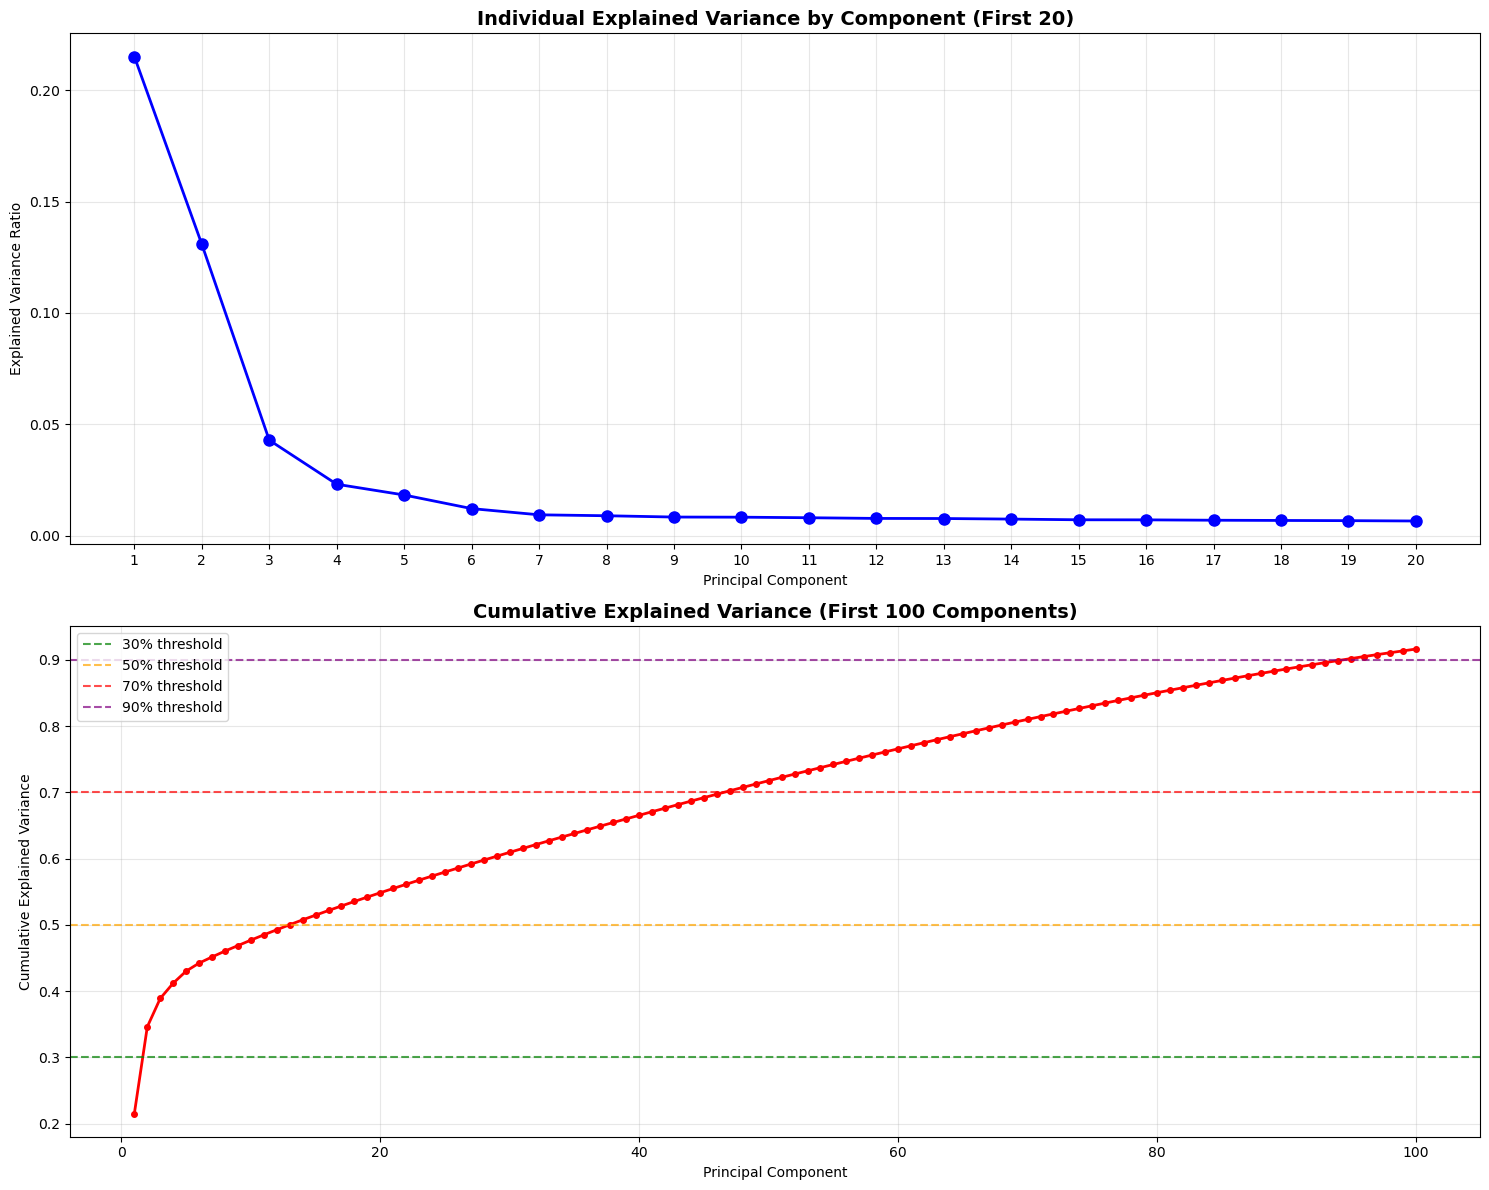

In [13]:
# Perform PCA on standardized data
print("=== PRINCIPAL COMPONENT ANALYSIS ===")
print(f"Input data shape: {X_scaled.shape}")

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

print(f"PCA output shape: {X_pca.shape}")
print(f"Number of components: {pca.n_components_}")

# Calculate explained variance metrics
explained_variance_ratio = pca.explained_variance_ratio_
explained_variance = pca.explained_variance_
cumulative_variance = np.cumsum(explained_variance_ratio)


print(f"\n=== TOP COMPONENTS BREAKDOWN ===")
for i in range(min(10, len(explained_variance_ratio))):
	print(f"PC{i+1:2d}: {explained_variance_ratio[i]:.4f} ({explained_variance_ratio[i]*100:5.2f}%) "
		  f"- Cumulative: {cumulative_variance[i]:.4f} ({cumulative_variance[i]*100:5.2f}%)")

# Quick visualization of individual variance contribution (first 20 components)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Top plot: Individual variance for first 20 components
ax1.plot(range(1, 21), explained_variance_ratio[:20], 'bo-', linewidth=2, markersize=8)
ax1.set_title('Individual Explained Variance by Component (First 20)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Principal Component')
ax1.set_ylabel('Explained Variance Ratio')
ax1.grid(True, alpha=0.3)
ax1.set_xticks(range(1, 21))

# Bottom plot: Cumulative variance for first 100 components
n_components_plot = min(100, len(cumulative_variance))
ax2.plot(range(1, n_components_plot + 1), cumulative_variance[:n_components_plot], 'ro-', linewidth=2, markersize=4)
ax2.axhline(y=0.30, color='g', linestyle='--', alpha=0.7, label='30% threshold')
ax2.axhline(y=0.50, color='orange', linestyle='--', alpha=0.7, label='50% threshold')
ax2.axhline(y=0.70, color='red', linestyle='--', alpha=0.7, label='70% threshold')
ax2.axhline(y=0.90, color='purple', linestyle='--', alpha=0.7, label='90% threshold')
ax2.set_title('Cumulative Explained Variance (First 100 Components)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Cumulative Explained Variance')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.subplots_adjust(hspace=0.4)  # Add space between plots
plt.tight_layout()
plt.show()

In [14]:
print(f"\n=== EXPLAINED VARIANCE ANALYSIS ===")
print(f"Total variance in original data: {np.sum(explained_variance):.3f}")

# Key thresholds for dimensionality reduction
variance_thresholds = [0.30, 0.40, 0.50, 0.70, 0.90]
for threshold in variance_thresholds:
	n_components = np.argmax(cumulative_variance >= threshold) + 1
	print(f"Components needed for {threshold*100:.0f}% variance: {n_components}")

# Transform back check (reconstruction accuracy)
print(f"\n=== RECONSTRUCTION ANALYSIS ===")
# Test reconstruction with different numbers of components
n_components_test = [5, 10, 20, 50]
for n_comp in n_components_test:
	if n_comp <= pca.n_components_:
		# Reconstruct using only first n components
		X_reconstructed = X_pca[:, :n_comp] @ pca.components_[:n_comp, :]
		reconstruction_error = np.mean((X_scaled - X_reconstructed)**2)
		print(f"Reconstruction error with {n_comp} components: {reconstruction_error:.6f} "
			  f"({cumulative_variance[n_comp-1]*100:.1f}% variance retained)")


=== EXPLAINED VARIANCE ANALYSIS ===
Total variance in original data: 157.010
Components needed for 30% variance: 2
Components needed for 40% variance: 4
Components needed for 50% variance: 13
Components needed for 70% variance: 47
Components needed for 90% variance: 95

=== RECONSTRUCTION ANALYSIS ===
Reconstruction error with 5 components: 0.468474 (43.0% variance retained)
Reconstruction error with 10 components: 0.430026 (47.7% variance retained)
Reconstruction error with 20 components: 0.371211 (54.8% variance retained)
Reconstruction error with 50 components: 0.232186 (71.8% variance retained)


Da wir das Domänenwissen haben, dass es 5 verschiedene Gewebearten sind \
-> erste 5 Hauptkomponenten wählen

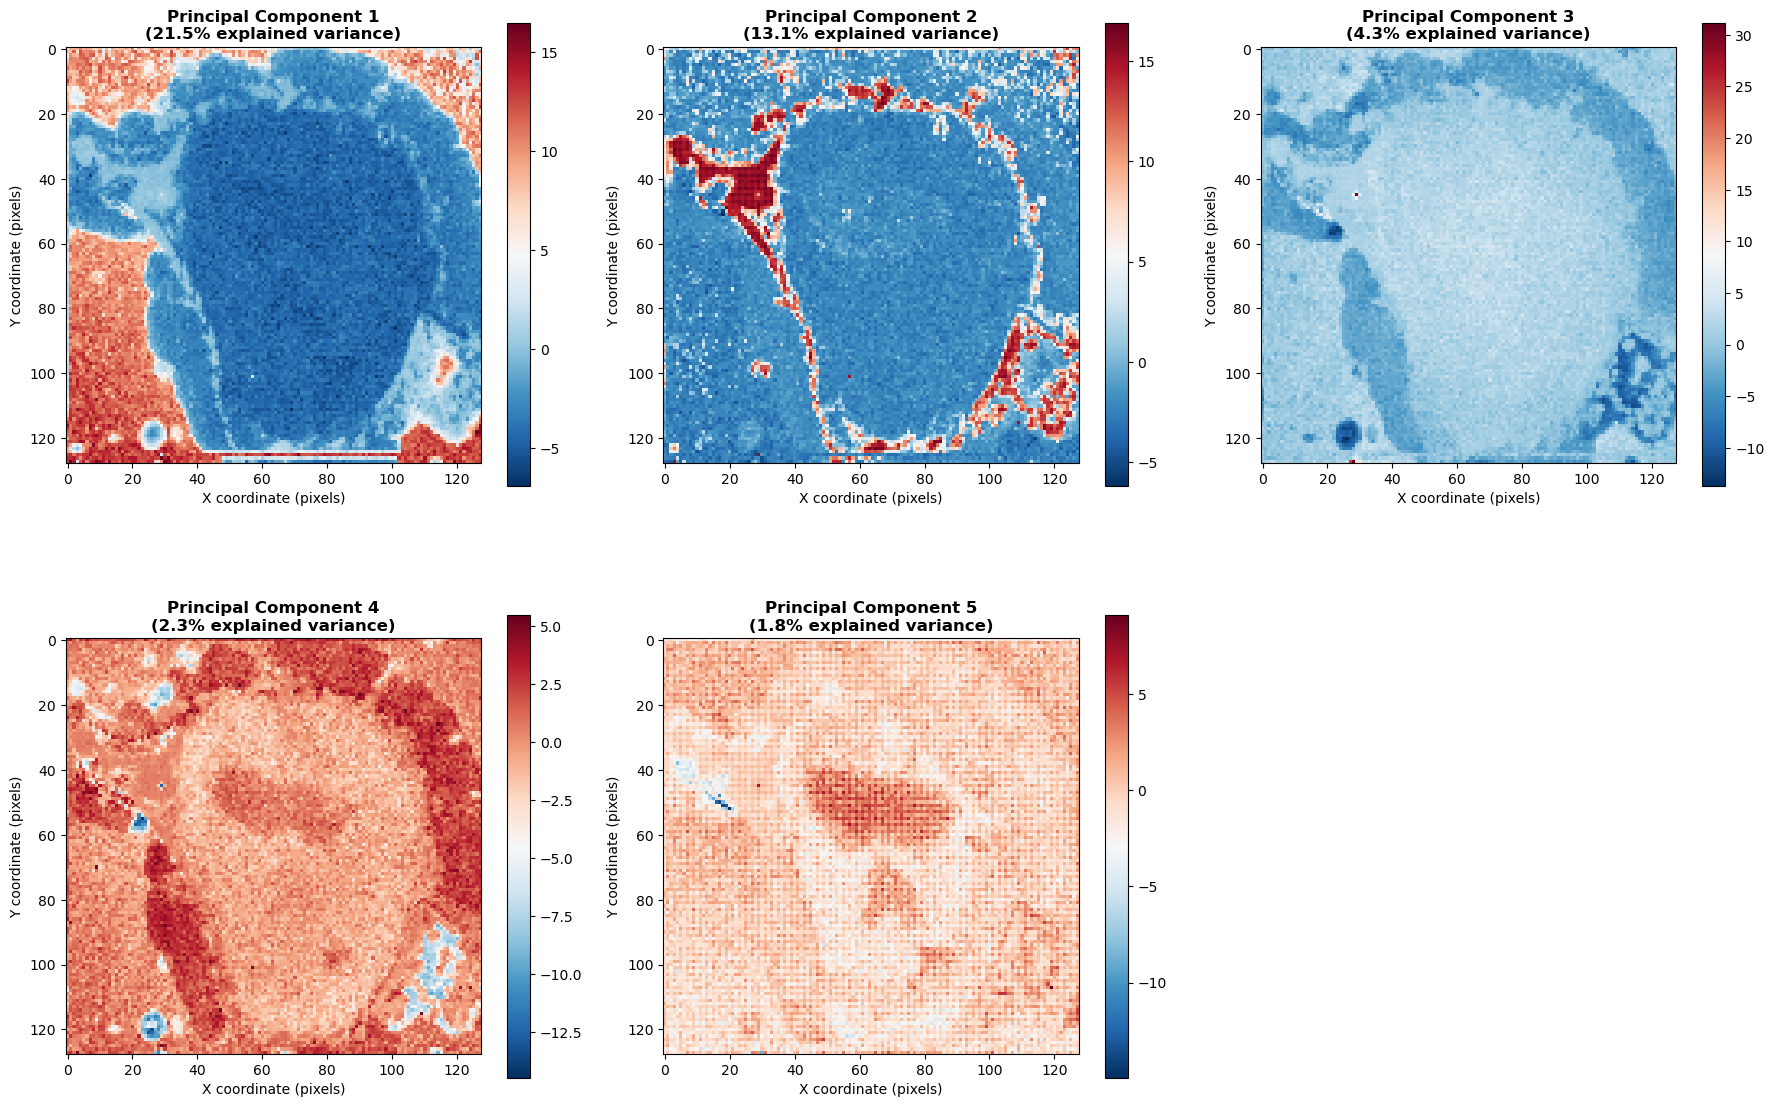

In [15]:
# Create individual 128x128 spatial plots for PC 1-5
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(5):
    row = i // 3
    col = i % 3
    
    # Reshape PC scores back to spatial dimensions
    pc_spatial = X_pca[:, i].reshape(height, width)
    
    # Create the plot
    im = axes[row, col].imshow(pc_spatial, cmap='RdBu_r', interpolation='nearest')
    axes[row, col].set_title(f'Principal Component {i+1}\n({explained_variance_ratio[i]:.1%} explained variance)', 
                           fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('X coordinate (pixels)')
    axes[row, col].set_ylabel('Y coordinate (pixels)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

# Hide the last subplot since we only have 5 components
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()




### NMF


=== NON-NEGATIVE MATRIX FACTORIZATION ===
Input data shape: (16384, 191)
Data shifted to non-negative range: [0.000, 57.683]
NMF output shape: (16384, 5)


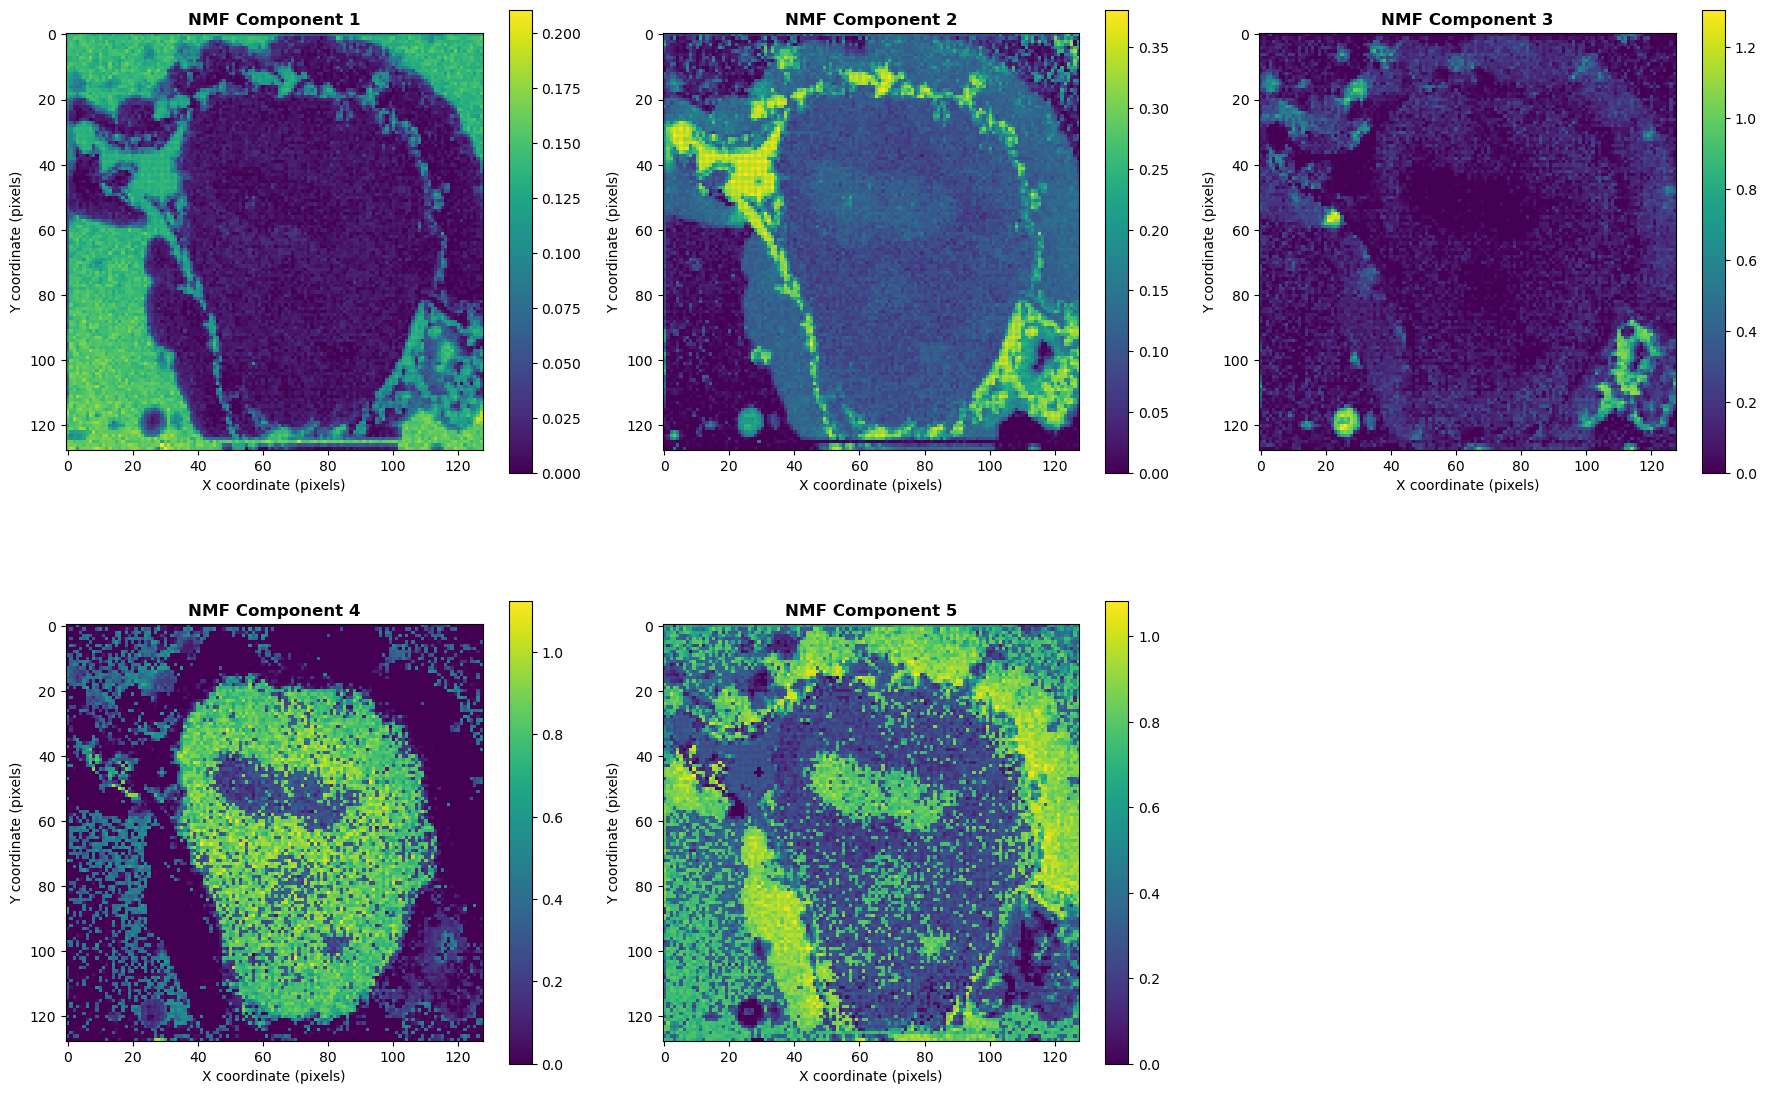

In [16]:
# Perform NMF on standardized data
print("=== NON-NEGATIVE MATRIX FACTORIZATION ===")
print(f"Input data shape: {X_scaled.shape}")

# NMF requires non-negative data, so we need to shift the standardized data
# Add the minimum value to make all values non-negative
X_shifted = X_scaled - np.min(X_scaled)
print(f"Data shifted to non-negative range: [{np.min(X_shifted):.3f}, {np.max(X_shifted):.3f}]")

# Apply NMF with reduced dimensionality
n_components_nmf = 5  # Use same number of components as ICA for comparison

# Apply NMF
nmf = NMF(n_components=5, random_state=42, max_iter=1000)
X_nmf = nmf.fit_transform(X_shifted)

print(f"NMF output shape: {X_nmf.shape}")


# Plot the top 5 NMF components spatially
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i in range(5):
    row = i // 3
    col = i % 3
    
    # Reshape NMF scores back to spatial dimensions
    nmf_spatial = X_nmf[:, i].reshape(height, width)
    
    # Create the plot
    im = axes[row, col].imshow(nmf_spatial, cmap='viridis', interpolation='nearest')
    axes[row, col].set_title(f'NMF Component {i+1}', 
                           fontsize=12, fontweight='bold')
    axes[row, col].set_xlabel('X coordinate (pixels)')
    axes[row, col].set_ylabel('Y coordinate (pixels)')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[row, col], shrink=0.8)

# Hide the last subplot since we only have 5 components
axes[1, 2].set_visible(False)

plt.tight_layout()
plt.show()